In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer, default_data_collator
from datasets import load_dataset, load_metric, ClassLabel, Sequence
import transformers
import pandas as pd
from IPython.display import display, HTML
import random
import numpy as np
import collections
from transformers import MarianMTModel, MarianTokenizer
from tqdm.auto import tqdm
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

transformers.__version__

Using cuda:0 device


'4.35.0'

In [3]:
squad_v2 = True
model_checkpoint = "distilbert-base-uncased"
batch_size = 32
max_length = 384
doc_stride = 128
n_best_size = 20
max_answer_length = 30

In [4]:
datasets1={}

In [5]:
datasets1['train'] = load_dataset("squad_v2", split='train[:90%]' if squad_v2 else "squad")
datasets1['validation'] = load_dataset("squad_v2", split='train[90%:100%]' if squad_v2 else "squad")
datasets1['test'] = load_dataset("squad_v2", split='validation' if squad_v2 else "squad")

In [6]:
datasets1

{'train': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 117287
 }),
 'validation': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 13032
 }),
 'test': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 11873
 })}

In [7]:
from datasets import Dataset, DatasetDict
datasets= DatasetDict(datasets1)
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 117287
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 13032
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

In [8]:
datasets['train']

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 117287
})

In [9]:
from mtranslate import translate

def back_translate(sentence):
    bt_sentences=[]
    for i in tqdm(range(len(sentence))):
        try:
            # Translate from English to French
            french_translation = translate(sentence[i], 'fr', 'en')

            # Translate from French back to English
            back_english_translation = translate(french_translation, 'en', 'fr')
        except:
            try:
                # Translate from English to French
                french_translation = translate(sentence[i], 'fr', 'en')

                # Translate from French back to English
                back_english_translation = translate(french_translation, 'en', 'fr')
            except:
                # Translate from English to French
                french_translation = translate(sentence[i], 'fr', 'en')

                # Translate from French back to English
                back_english_translation = translate(french_translation, 'en', 'fr')
        bt_sentences.append(back_english_translation)
    return bt_sentences

In [10]:
# Get the total number of examples in the dataset
total_examples = len(datasets["train"]["question"])

# Set the number of samples you want to extract
num_samples = 5000

# Generate 10,000 random indices with uniform probability
random_indices = random.sample(range(total_examples), num_samples)

# Extract samples based on the random indices
sampled_data = {
    "question": [datasets["train"]["question"][i] for i in tqdm(random_indices,desc='processing')],
    "context": [datasets["train"]["context"][i] for i in tqdm(random_indices,desc='processing')],
    "answers": [datasets["train"]["answers"][i] for i in tqdm(random_indices,desc='processing')],
    "id": [datasets["train"]["id"][i] for i in tqdm(random_indices,desc='processing')],
    "title": [datasets["train"]["title"][i] for i in tqdm(random_indices,desc='processing')]
}

processing: 100%|███████████████████████████| 5000/5000 [08:31<00:00,  9.78it/s]


In [11]:
# Apply back translation to the context and question in the SQuAD dataset
context_texts = sampled_data["context"]
question_texts = sampled_data["question"]
answer_texts= sampled_data['answers']
id_texts= sampled_data['id']
title_texts= sampled_data['title']

In [12]:
len(question_texts)

5000

In [13]:
# Translate from English to French
# context_translations = back_translate(context_texts, model, tokenizer)
question_translations = back_translate(question_texts)

100%|█████████████████████████████████████| 5000/5000 [1:11:44<00:00,  1.16it/s]


In [14]:
# Create augmented dataset with back-translated context, questions, and answers
augmented_dataset = {
    "context": context_texts,
    "question": question_translations,
    "answers": answer_texts,  # Add this line
    "id": id_texts,
    "title": title_texts,
}

In [15]:
len(augmented_dataset['question'])

5000

In [16]:
# Optionally, you can combine the original and augmented datasets
combined_dataset = {
    "context": datasets["train"]["context"]+context_texts,
    "question": datasets["train"]["question"] + question_translations,
    "answers": datasets["train"]["answers"] + answer_texts,
    "id":datasets["train"]["id"] + id_texts,
    "title":datasets["train"]["title"]+ title_texts
}

In [17]:
len(combined_dataset['question'])

122287

In [18]:
datasets['train'] = Dataset.from_dict(combined_dataset)

In [19]:
datasets

DatasetDict({
    train: Dataset({
        features: ['context', 'question', 'answers', 'id', 'title'],
        num_rows: 122287
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 13032
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

In [20]:
datasets["validation"]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 13032
})

In [21]:
# Show random elements in the dataset
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [22]:
len(datasets["train"])

122287

In [23]:
show_random_elements(datasets["train"])

,context,question,answers,id,title
0,"The interactions of carbonate anions with uranium(VI) cause the Pourbaix diagram to change greatly when the medium is changed from water to a carbonate containing solution. While the vast majority of carbonates are insoluble in water (students are often taught that all carbonates other than those of alkali metals are insoluble in water), uranium carbonates are often soluble in water. This is because a U(VI) cation is able to bind two terminal oxides and three or more carbonates to form anionic complexes.",What does a uranium(VI) cation form when it binds to two terminal oxides and three or more carbonates?,"{'answer_start': [491], 'text': ['anionic complexes']}",570e357f0b85d914000d7d69,Uranium
1,"In Theravada Buddhism there can be no divine salvation or forgiveness for one's karma, since it is a purely impersonal process that is a part of the makeup of the universe.[citation needed] In Mahayana Buddhism, the texts of certain Mahayana sutras (such as the Lotus Sutra, the Aṅgulimālīya Sūtra and the Mahāyāna Mahāparinirvāṇa Sūtra) claim that the recitation or merely the hearing of their texts can expunge great swathes of negative karma. Some forms of Buddhism (for example, Vajrayana) regard the recitation of mantras as a means for cutting off of previous negative karma. The Japanese Pure Land teacher Genshin taught that Amitābha has the power to destroy the karma that would otherwise bind one in saṃsāra.",What Buddhism says that salvation is unattainable?,"{'answer_start': [3], 'text': ['Theravada Buddhism']}",56d125a117492d1400aaba7d,Buddhism
2,"The demographics of the British Isles today are characterised by a generally high density of population in England, which accounts for almost 80% of the total population of the islands. In elsewhere on Great Britain and on Ireland, high density of population is limited to areas around, or close to, a few large cities. The largest urban area by far is the Greater London Urban Area with 9 million inhabitants. Other major populations centres include Greater Manchester Urban Area (2.4 million), West Midlands conurbation (2.4 million), West Yorkshire Urban Area (1.6 million) in England, Greater Glasgow (1.2 million) in Scotland and Greater Dublin Area (1.1 million) in Ireland.[citation needed]",Which is the smallest urban area with only 9 million people?,"{'answer_start': [], 'text': []}",5acd935e07355d001abf477f,British_Isles
3,"Besides emptiness, Mahayana schools often place emphasis on the notions of perfected spiritual insight (prajñāpāramitā) and Buddha-nature (tathāgatagarbha). There are conflicting interpretations of the tathāgatagarbha in Mahāyāna thought. The idea may be traced to Abhidharma, and ultimately to statements of the Buddha in the Nikāyas. In Tibetan Buddhism, according to the Sakya school, tathāgatagarbha is the inseparability of the clarity and emptiness of one's mind. In Nyingma, tathāgatagarbha also generally refers to inseparability of the clarity and emptiness of one's mind. According to the Gelug school, it is the potential for sentient beings to awaken since they are empty (i.e. dependently originated). According to the Jonang school, it refers to the innate qualities of the mind that expresses themselves as omniscience etc. when adventitious obscurations are removed. The ""Tathāgatagarbha Sutras"" are a collection of Mahayana sutras that present a unique model of Buddha-nature. Even though this collection was generally ignored in India, East Asian Buddhism provides some significance to these texts.",What does tathagatagarbha mean?,"{'answer_start': [124], 'text': ['Buddha-nature']}",56d1ebdfe7d4791d00902577,Buddhism
4,"Immigration to Israel during the late 1940s and early 1950s was aided by the Israeli Immigration Department and the non-government sponsored Mossad LeAliyah Bet (""Institution for Illegal Immigration""). Both groups facilitated regular immigration logistics like arranging transportation, but the latter also eng

In [24]:
# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [25]:
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [26]:
tokenizer("What is your name?", "My name is Minhah.")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 102, 2026, 2171, 2003, 19538, 4430, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [27]:
for i, example in enumerate(datasets["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
        break
example = datasets["train"][i]

In [28]:
len(tokenizer(example["question"], example["context"])["input_ids"])

437

In [29]:
len(tokenizer(example["question"], example["context"], max_length=max_length, truncation="only_second")["input_ids"])

384

In [30]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

In [31]:
[len(x) for x in tokenized_example["input_ids"]]

[384, 192]

In [32]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] beyonce got married in 2008 to whom? [SEP] on april 4, 2008, beyonce married jay z. she publicly revealed their marriage in a video montage at the listening party for her third studio album, i am... sasha fierce, in manhattan's sony club on october 22, 2008. i am... sasha fierce was released on november 18, 2008 in the united states. the album formally introduces beyonce's alter ego sasha fierce, conceived during the making of her 2003 single " crazy in love ", selling 482, 000 copies in its first week, debuting atop the billboard 200, and giving beyonce her third consecutive number - one album in the us. the album featured the number - one song " single ladies ( put a ring on it ) " and the top - five songs " if i were a boy " and " halo ". achieving the accomplishment of becoming her longest - running hot 100 single in her career, " halo "'s success in the us helped beyonce attain more top - ten singles on the list than any other woman during the 2000s. it also included the suc

In [33]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 7), (8, 11), (12, 19), (20, 22), (23, 27), (28, 30), (31, 35), (35, 36), (0, 0), (0, 2), (3, 8), (9, 10), (10, 11), (12, 16), (16, 17), (18, 25), (26, 33), (34, 37), (38, 39), (39, 40), (41, 44), (45, 53), (54, 62), (63, 68), (69, 77), (78, 80), (81, 82), (83, 88), (89, 93), (93, 96), (97, 99), (100, 103), (104, 113), (114, 119), (120, 123), (124, 127), (128, 133), (134, 140), (141, 146), (146, 147), (148, 149), (150, 152), (152, 153), (153, 154), (154, 155), (156, 161), (162, 168), (168, 169), (170, 172), (173, 182), (182, 183), (183, 184), (185, 189), (190, 194), (195, 197), (198, 205), (206, 208), (208, 209), (210, 214), (214, 215), (216, 217), (218, 220), (220, 221), (221, 222), (222, 223), (224, 229), (230, 236), (237, 240), (241, 249), (250, 252), (253, 261), (262, 264), (264, 265), (266, 270), (271, 273), (274, 277), (278, 284), (285, 291), (291, 292), (293, 296), (297, 302), (303, 311), (312, 322), (323, 330), (330, 331), (331, 332), (333, 338), (339, 342), (343, 3

In [34]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

beyonce Beyonce


In [35]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [36]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

18 19


In [37]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answers["text"][0])

jay z
Jay Z


In [38]:
pad_on_right = tokenizer.padding_side == "right"

In [39]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

# Move model to GPU
model.to(device)

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

In [40]:
# Preprocessing the training data
def prepare_train_features(examples):
    examples["question"] = [q.lstrip() for q in examples["question"]]
    tokenized_examples = tokenizer(
        examples["question" if tokenizer.padding_side == "right" else "context"],
        examples["context" if tokenizer.padding_side == "right" else "question"],
        truncation="only_second" if tokenizer.padding_side == "right" else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(tokenized_examples["offset_mapping"]):
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        sequence_ids = tokenized_examples.sequence_ids(i)
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if tokenizer.padding_side == "right" else 0):
                token_start_index += 1
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if tokenizer.padding_side == "right" else 0):
                token_end_index -= 1

            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [41]:
features = prepare_train_features(datasets['train'][:5])

In [42]:
# Map training features to GPU
tokenized_datasets = datasets.map(
    prepare_train_features,
    batched=True,
    remove_columns=datasets["train"].column_names
)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'start_positions', 'end_positions'])

Map:   0%|          | 0/122287 [00:00<?, ? examples/s]

In [43]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-squad",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    push_to_hub=True,
)

In [44]:
data_collator = default_data_collator

In [45]:
# Define trainer
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)


In [47]:
trainer.train()

/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,1.295000,1.229331
2,0.912700,1.211192
3,0.667300,1.380019
4,0.490700,1.486625
5,0.359000,1.651984


/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
 

TrainOutput(global_step=9665, training_loss=0.7926851496570664, metrics={'train_runtime': 10281.3902, 'train_samples_per_second': 60.137, 'train_steps_per_second': 0.94, 'total_flos': 6.058612891408896e+16, 'train_loss': 0.7926851496570664, 'epoch': 5.0})

In [48]:
trainer.save_model("test-squad-trained-bt")

events.out.tfevents.1702236024.a100.1500631.0:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

In [49]:
# Evaluation
for batch in trainer.get_eval_dataloader():
    break

batch = {k: v.to(device) for k, v in batch.items()}
with torch.no_grad():
    output = model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [50]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([64, 384]), torch.Size([64, 384]))

In [51]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([102, 134,   0,   0,  13,  34,  55,  66, 102,  31,  37,  52,  69,  10,
          45,  65,  77,  94,   0,   0,   0,  28,  31,  55, 117, 142,   0,  51,
          45,  97, 135,  30,   0,   0,   0,  26,  28,  52,  63, 132,   0,  76,
           0,  18,  29,  78, 106, 166,   0,  18,   0, 139,  51,  52,  55,  92,
         152,   0,   0,   0,  26,  75,  75,  71], device='cuda:0'),
 tensor([105, 138,   0,   0,  15,  35,  56,  71, 106,  34,  51,  53,  70,  13,
          45,  66,  80,  96,   0,   0,   0,  29,  34,  61, 118, 142,   0,  56,
          59,  99, 138,  37,   0,   0,   0,   0,  29,  59,  64,   0,   0,  78,
           0,  24,  43,  79, 106, 166,   0,  24,   0, 141,  62,  54,  55,  94,
         158,   0,   0,   0,  29,  76,  76,  72], device='cuda:0'))

In [52]:
n_best_size = 20

In [53]:
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

In [54]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [55]:
# Map validation features to GPU
validation_features = datasets["test"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["test"].column_names
)
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

In [56]:
# Predictions on GPU
raw_predictions = trainer.predict(validation_features)

In [57]:
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

In [58]:
max_answer_length = 30

In [59]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = datasets["test"][0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 14.426487, 'text': 'assimilation and mixing with'},
 {'score': 8.344841, 'text': 'with'},
 {'score': 8.105002, 'text': 'generations of assimilation and mixing with'},
 {'score': 7.490836,
  'text': 'assimilation and mixing with the native Frankish and Roman-Gaulish populations, their'},
 {'score': 6.8579707, 'text': 'assimilation'},
 {'score': 6.839307,
  'text': 'Through generations of assimilation and mixing with'},
 {'score': 6.572864, 'text': 'assimilation and mixing with the'},
 {'score': 6.0581303,
  'text': 'assimilation and mixing with the native Frankish and Roman-Gaulish populations,'},
 {'score': 5.9588313, 'text': 'mixing with'},
 {'score': 5.65364, 'text': 'assimilation and mixing'},
 {'score': 3.4764125,
  'text': 'assimilation and mixing with the native Frankish and Roman-'},
 {'score': 3.456499,
  'text': 'assimilation and mixing with the native Frankish and Roman'},
 {'score': 3.2252884, 'text': 'of assimilation and mixing with'},
 {'score': 2.8456287, 'text

In [60]:
datasets["test"][0]["answers"]

{'text': ['France', 'France', 'France', 'France'],
 'answer_start': [159, 159, 159, 159]}

In [61]:
import collections

examples = datasets["test"]
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

In [62]:
# Postprocess QA predictions
def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size=20, max_answer_length=30):
    all_start_logits, all_end_logits = raw_predictions
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)

    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    predictions = collections.OrderedDict()

    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    for example_index, example in enumerate(tqdm(examples)):
        feature_indices = features_per_example[example_index]
        min_null_score = None
        valid_answers = []
        context = example["context"]

        for feature_index in feature_indices:
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            offset_mapping = features[feature_index]["offset_mapping"]

            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]

            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            start_indexes = np.argsort(start_logits)[-1: -n_best_size - 1: -1].tolist()
            end_indexes = np.argsort(end_logits)[-1: -n_best_size - 1: -1].tolist()

            for start_index in start_indexes:
                for end_index in end_indexes:
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue

                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            best_answer = {"text": "", "score": 0.0}

        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

# Map validation features to GPU
validation_features = datasets["test"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["test"].column_names
)
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

# Predictions on GPU
raw_predictions = trainer.predict(validation_features)

In [63]:
# Postprocess predictions
final_predictions = postprocess_qa_predictions(datasets["test"], validation_features, raw_predictions.predictions)

Post-processing 11873 example predictions split into 12134 features.


100%|████████████████████████████████████| 11873/11873 [00:30<00:00, 390.68it/s]


In [64]:
metric = load_metric("squad_v2" if squad_v2 else "squad")

/tmp/ipykernel_1500631/2905994612.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if squad_v2 else "squad")


In [65]:
metric = load_metric("squad_v2" if squad_v2 else "squad")

if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["test"]]
metric.compute(predictions=formatted_predictions, references=references)

{'exact': 63.73283921502569,
 'f1': 67.77227203680067,
 'total': 11873,
 'HasAns_exact': 66.44736842105263,
 'HasAns_f1': 74.53781813308572,
 'HasAns_total': 5928,
 'NoAns_exact': 61.026072329688816,
 'NoAns_f1': 61.026072329688816,
 'NoAns_total': 5945,
 'best_exact': 63.73283921502569,
 'best_exact_thresh': 0.0,
 'best_f1': 67.77227203680091,
 'best_f1_thresh': 0.0}

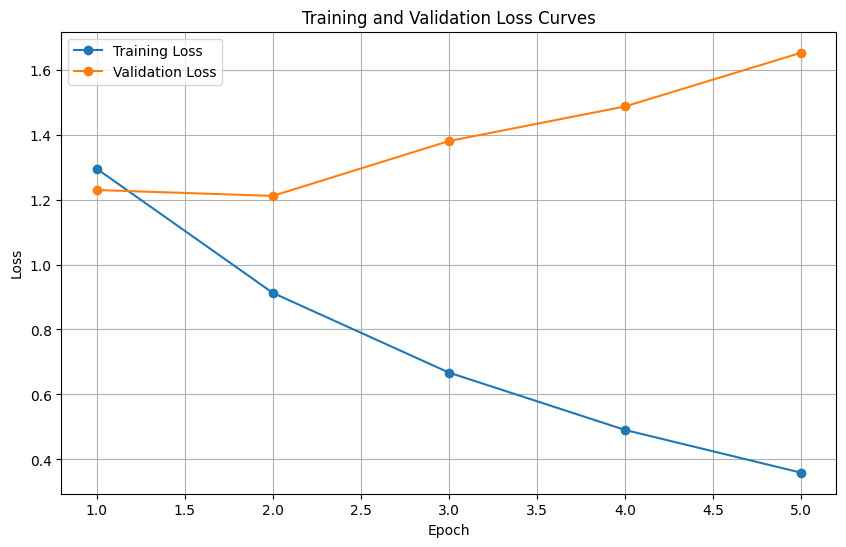

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with your data
data = {
    'Epoch': [1, 2, 3, 4, 5],
    'Training Loss': [1.295000,0.912700,0.667300,0.490700,0.359000],
    'Validation Loss': [1.229331,1.211192,1.380019,1.486625,1.651984]
}

df = pd.DataFrame(data)

# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(df['Epoch'], df['Training Loss'], label='Training Loss', marker='o')
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss', marker='o')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Show the plot
plt.grid()
plt.show()
